<a href="https://colab.research.google.com/github/MarogobaCTD/UFPR/blob/main/TRABALHO_DE_IAA011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRABALHO DE IAA011 – Visão Computacional

## 1 Extração de Características


### Setup

In [1]:
train_directory  = r'/content/Train_4cls_amostra'
test_directory   = r'/content/Test_4cl_amostra'
output_directory = r'/content/'

In [2]:
!unzip -o Train_Warwick.zip
!unzip -o Test_Warwick.zip

Archive:  Train_Warwick.zip
  inflating: Train_4cls_amostra/0/46_HER2_61709.png  
  inflating: Train_4cls_amostra/0/46_HER2_64186.png  
  inflating: Train_4cls_amostra/0/13_HER2_10243.png  
  inflating: Train_4cls_amostra/0/46_HER2_58961.png  
  inflating: Train_4cls_amostra/0/46_HER2_64180.png  
  inflating: Train_4cls_amostra/0/46_HER2_55795.png  
  inflating: Train_4cls_amostra/0/18_HER2_25188.png  
  inflating: Train_4cls_amostra/0/13_HER2_11145.png  
  inflating: Train_4cls_amostra/0/13_HER2_2910.png  
  inflating: Train_4cls_amostra/0/01_HER2_4962.png  
  inflating: Train_4cls_amostra/0/18_HER2_30785.png  
  inflating: Train_4cls_amostra/0/13_HER2_11144.png  
  inflating: Train_4cls_amostra/0/01_HER2_4153.png  
  inflating: Train_4cls_amostra/0/57_HER2_6110.png  
  inflating: Train_4cls_amostra/0/01_HER2_7841.png  
  inflating: Train_4cls_amostra/0/01_HER2_6435.png  
  inflating: Train_4cls_amostra/0/13_HER2_11396.png  
  inflating: Train_4cls_amostra/0/18_HER2_22017.png  
  infl

### Importação das bibliotecas

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns


### Cálculo de LBP

In [4]:
def calculate_lbp(img):
    # Converter para escala de cinza
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Definir parâmetros do LBP
    radius = 1
    n_points = 8 * radius

    # Criar uma imagem LBP vazia
    lbp = np.zeros_like(gray_image, dtype=np.uint8)

    # Calcular LBP
    for i in range(radius, gray_image.shape[0] - radius):
        for j in range(radius, gray_image.shape[1] - radius):
            center = gray_image[i, j]
            binary_values = []
            for p in range(n_points):
                theta = 2 * np.pi * p / n_points
                x = int(i + radius * np.sin(theta))
                y = int(j + radius * np.cos(theta))
                binary_values.append(int(gray_image[x, y] > center))

            lbp[i, j] = sum([val * (2 ** idx) for idx, val in enumerate(binary_values)])

    # Calcular o histograma LBP
    hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
    return hist / np.sum(hist)  # Normalizando o histograma

### Cálculo de VGG16

In [5]:
def extract_vgg_features(img_path, model):
    imagem = cv2.imread(img_path)
    imagem = cv2.resize(imagem, (224, 224))  # Redimensiona para 224x224
    imagem = np.array(imagem) / 255.0  # Normaliza para [0, 1]
    imagem = np.expand_dims(imagem, axis=0)  # Adiciona uma dimensão para o batch

    # Extrair características
    features = model.predict(imagem)
    return features.flatten()

In [6]:
vgg16 = VGG16(weights='imagenet', include_top=False)
modelo_vgg = Model(inputs=vgg16.input, outputs=vgg16.output)

### Criação os DataFrames das imagens

In [7]:
def criar_dataframe_imagens(directory):
  #cria uma lista com todos os arquivos das pastas
  lista_imagens = []
  labels = []
  for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                lista_imagens.append(img_path)
                labels.append(label)

  #print(lista_imagens)
  df = pd.DataFrame(lista_imagens, columns=['imagem'])
  df['label'] = labels

  # Extrai o número do paciente (XX) da nomenclatura das imagens
  df['paciente_id'] = df['imagem'].apply(lambda x: x.split('/')[-1].split('_')[0])

  return df

### Separação dos dados do Treino para Treinamento e Validação

In [8]:
def separacao_treina_validacao(directory):
  # Carregar as imagens
  df_imagens = criar_dataframe_imagens(directory)
  #print(df_imagens)

  # Separa os IDs de pacientes
  pacientes_unicos = df_imagens['paciente_id'].unique()
  print(pacientes_unicos)

  # Divide os pacientes em treino e validação (80% para treino e 20% para validação)
  num_pacientes = len(pacientes_unicos)
  print(num_pacientes)
  num_treino = int(num_pacientes * 0.8)
  print(num_treino)

  # Ordena os pacientes para garantir uma separação não randômica
  pacientes_ordenados = sorted(pacientes_unicos)
  pacientes_treino = pacientes_ordenados[:num_treino]
  print(pacientes_treino)
  pacientes_validacao = pacientes_ordenados[num_treino:]
  print(pacientes_validacao)

  # Cria DataFrames para treino e validação
  df_treino = df_imagens[df_imagens['paciente_id'].isin(pacientes_treino)]
  df_validacao = df_imagens[df_imagens['paciente_id'].isin(pacientes_validacao)]

  # Exibe os DataFrames resultantes
  return df_treino, df_validacao

In [9]:
def separacao_treina_validacao(directory):
    # Carregar as imagens
    df_imagens = criar_dataframe_imagens(directory)  # Supondo que cria um DataFrame com 'paciente_id' e 'classe'

    # Inicializa listas para armazenar pacientes de treino e validação
    pacientes_treino = []
    pacientes_validacao = []

    # Loop por cada classe para realizar a separação de pacientes por classe
    for classe in df_imagens['label'].unique():
        # Filtra o DataFrame para a classe atual
        df_classe = df_imagens[df_imagens['label'] == classe]

        # Identifica pacientes únicos dentro da classe atual
        pacientes_unicos = df_classe['paciente_id'].unique()
        #print(pacientes_unicos)

        # Determina a quantidade para treino e validação (80% treino e 20% validação)
        num_pacientes = len(pacientes_unicos)
        num_treino = int(num_pacientes * 0.8)

        # Ordena os pacientes para garantir a consistência
        pacientes_ordenados = sorted(pacientes_unicos)

        # Seleciona 80% para treino e 20% para validação
        pacientes_treino += pacientes_ordenados[:num_treino]
        #print(pacientes_treino)
        pacientes_validacao += pacientes_ordenados[num_treino:]
        #print(pacientes_validacao)

    # Cria DataFrames de treino e validação com todos os pacientes selecionados
    df_treino = df_imagens[df_imagens['paciente_id'].isin(pacientes_treino)]
    df_validacao = df_imagens[df_imagens['paciente_id'].isin(pacientes_validacao)]

    # Verifica se cada conjunto possui todas as classes
    print("Classes em treino:", df_treino['label'].value_counts())
    print("Classes em validação:", df_validacao['label'].value_counts())

    return df_treino, df_validacao

### Particionamento da base de Treino (80 % treino e 20% Validação)

In [10]:
# Separação dos dataframes de treino e validacao
df_treino, df_validacao = separacao_treina_validacao(train_directory)
print(df_treino)
print(df_validacao)

['11' '19' '22' '09' '06']
['06', '09', '11', '19']
['22']
['15' '24' '29' '14' '16']
['06', '09', '11', '19', '14', '15', '16', '24']
['22', '29']
['46' '57' '18' '01' '13']
['06', '09', '11', '19', '14', '15', '16', '24', '01', '13', '18', '46']
['22', '29', '57']
['25' '36' '26' '32' '04']
['06', '09', '11', '19', '14', '15', '16', '24', '01', '13', '18', '46', '04', '25', '26', '32']
['22', '29', '57', '36']
Classes em treino: label
3    120
2    120
1    117
0    116
Name: count, dtype: int64
Classes em validação: label
3    30
1    30
0    30
2    30
Name: count, dtype: int64
                                              imagem label paciente_id
0    /content/Train_4cls_amostra/3/11_HER2_14616.png     3          11
1    /content/Train_4cls_amostra/3/19_HER2_19390.png     3          19
3    /content/Train_4cls_amostra/3/11_HER2_12905.png     3          11
4    /content/Train_4cls_amostra/3/19_HER2_19916.png     3          19
6    /content/Train_4cls_amostra/3/09_HER2_12658.png    

### Extração das caracteristicas

In [11]:
def extrair_caracteristicas(df, output_directory, extrator):
  features_lbp = []
  features_vgg = []
  labels = []

  for index, row in df.iterrows():
        # Carregar a imagem
        img = cv2.imread(row['imagem'])

        # Extrair características LBP
        lbp_features = calculate_lbp(img)
        features_lbp.append(lbp_features)

        # Extrair características VGG
        vgg_features = extract_vgg_features(row['imagem'], modelo_vgg)
        features_vgg.append(vgg_features)

        # Adicionar o rótulo
        #labels.append(row['imagem'].split('/')[-2])

  # Convertendo para arrays
  features_lbp = np.array(features_lbp)
  features_vgg = np.array(features_vgg)
  labels       = np.array(df['label'])

  # Criando DataFrames para exportação
  df_lbp    = pd.DataFrame(features_lbp)
  df_vgg    = pd.DataFrame(features_vgg)
  df_labels = pd.DataFrame(labels, columns=['Label'])

  nome_arquivo_lbp    = extrator + '_features_lbp.csv'
  nome_arquivo_vgg    = extrator + '_features_vgg.csv'
  nome_arquivo_labels = extrator + '_labels.csv'

  # Exportando para CSV
  df_lbp.to_csv(os.path.join(output_directory, nome_arquivo_lbp), index=False)
  df_vgg.to_csv(os.path.join(output_directory, nome_arquivo_vgg), index=False)
  df_labels.to_csv(os.path.join(output_directory, nome_arquivo_labels), index=False)

  return features_lbp, features_vgg, labels

### Extrai características utilizando LBP e a CNN VGG16 (gerando um csv para cada extrator).


In [12]:
# Extrair as caracteristicas da base de Treino
X_train_lbp, X_train_vgg, y_train = extrair_caracteristicas(df_treino, output_directory, 'train')

# Extrair as caracteristicas da base de validacao
X_valid_lbp, X_valid_vgg, y_valid = extrair_caracteristicas(df_validacao, output_directory, 'valid')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960

### Calculo de Especificidade

In [13]:
def specificity_score(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  tn = cm.diagonal().sum()  # Soma da diagonal dos verdadeiros negativos
  fp = cm.sum(axis=0) - cm.diagonal()  # Falsos positivos
  return tn / (tn + fp.sum())

### Calculo das métricas dos modelos

In [14]:
def exibir_metricas(y_test, y_pred):
  accuracy    = accuracy_score(y_test, y_pred)
  recall      = recall_score(y_test, y_pred, average='macro')
  specificity = specificity_score(y_test, y_pred)
  f1          = f1_score(y_test, y_pred, average='macro')
  conf_matrix = confusion_matrix(y_test, y_pred)

  print(f'Acurácia: {accuracy:.4f}')
  print(f'Sensibilidade (Recall): {recall:.4f}')
  print(f'Especificidade: {specificity:.4f}')
  print(f'F1-Score: {f1:.4f}')

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.title('Matriz de Confusão')
  plt.xlabel('Previsão')
  plt.ylabel('Verdadeiro')
  plt.show()

### Random Florest

In [15]:
def random_forest(X_train_lbp, X_train_vgg, y_train):
  # Treinar Random Forest com LBP
  rf_model_lbp = RandomForestClassifier(n_estimators=100, random_state=42)
  rf_model_lbp.fit(X_train_lbp, y_train)

  # Treinar Random Forest com VGG
  rf_model_vgg = RandomForestClassifier(n_estimators=100, random_state=42)
  rf_model_vgg.fit(X_train_vgg, y_train)  # Treinamento apenas no conjunto de treino
  return rf_model_lbp, rf_model_vgg

### SVM

In [16]:
def svm(X_train_lbp, X_train_vgg, y_train):
  # Treinar SVM com LBP
  svm_model_lbp = SVC(kernel='linear', random_state=42)
  svm_model_lbp.fit(X_train_lbp, y_train)

  # Treinar SVM com VGG
  svm_model_vgg = SVC(kernel='linear', random_state=42)
  svm_model_vgg.fit(X_train_vgg, y_train)
  return svm_model_lbp, svm_model_vgg

### Redes Neurais Artificiais

In [17]:
def rna(X_train_lbp, X_train_vgg, y_train):
  # Treinar RNA com LBP
  rna_model_lbp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
  rna_model_lbp.fit(X_train_lbp, y_train)

  # Treinar RNA com VGG
  rna_model_vgg = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
  rna_model_vgg.fit(X_train_vgg, y_train)
  return rna_model_lbp, rna_model_vgg

In [18]:
def predicoes_metricas(model, X_test, y_test):
  y_pred = model.predict(X_test)
  exibir_metricas(y_test, y_pred)


### Treinamento com os dados de Treino e validação

Métricas para Randon Forest usando LBP:
Acurácia: 0.4583
Sensibilidade (Recall): 0.4583
Especificidade: 0.4583
F1-Score: 0.4380


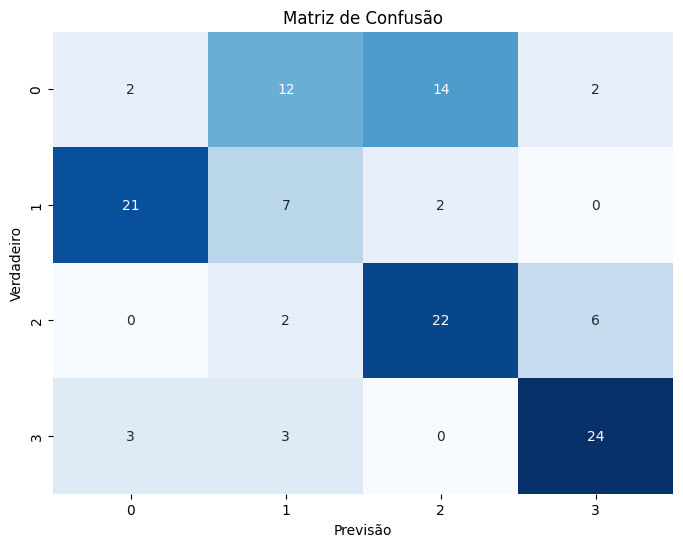

Métricas para Randon Forest usando VGG:
Acurácia: 0.6750
Sensibilidade (Recall): 0.6750
Especificidade: 0.6750
F1-Score: 0.5934


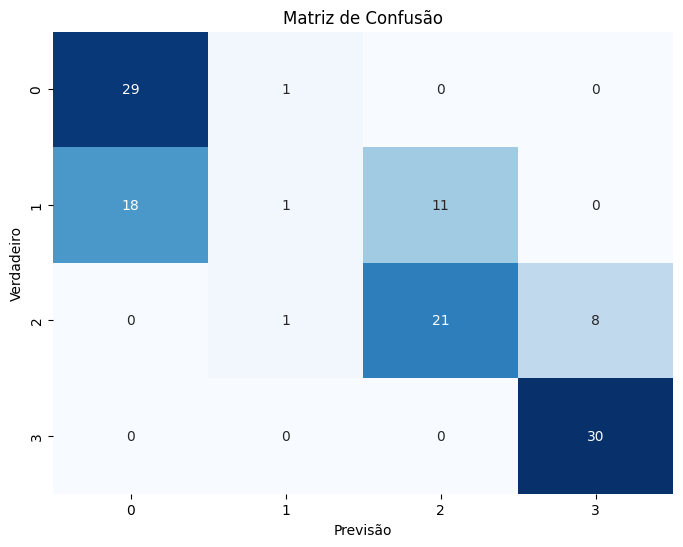

Métricas para SVM usando LBP:
Acurácia: 0.3333
Sensibilidade (Recall): 0.3333
Especificidade: 0.3333
F1-Score: 0.2393


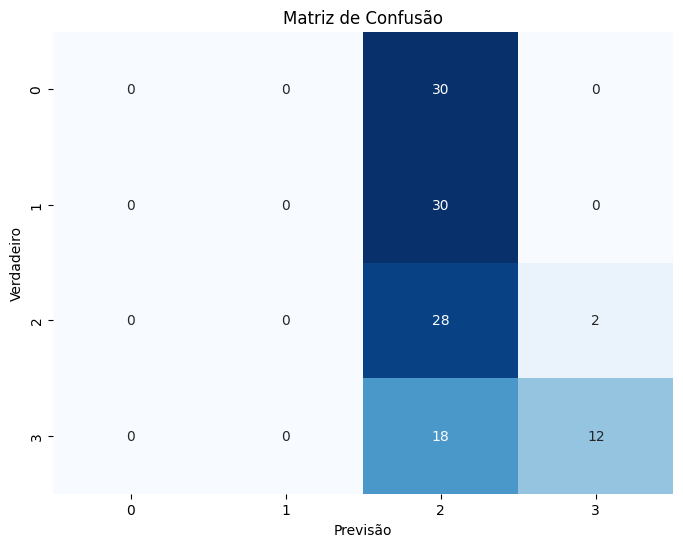

Métricas para SVM usando VGG:
Acurácia: 0.7833
Sensibilidade (Recall): 0.7833
Especificidade: 0.7833
F1-Score: 0.7507


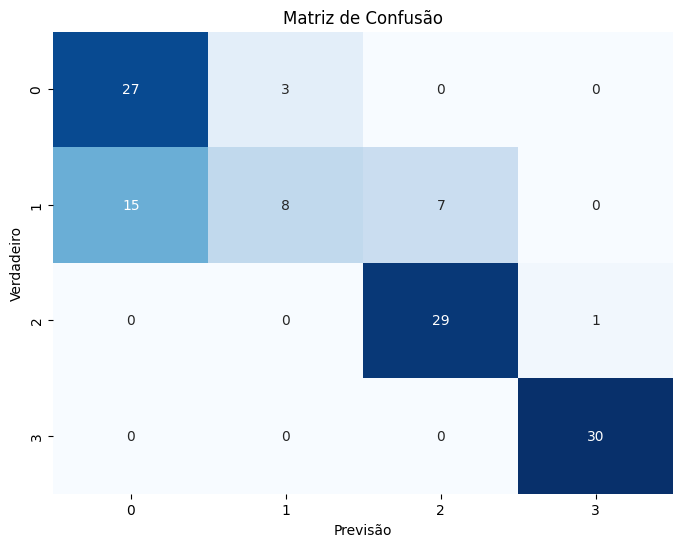

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Métricas para RNA usando LBP:
Acurácia: 0.3667
Sensibilidade (Recall): 0.3667
Especificidade: 0.3667
F1-Score: 0.2914


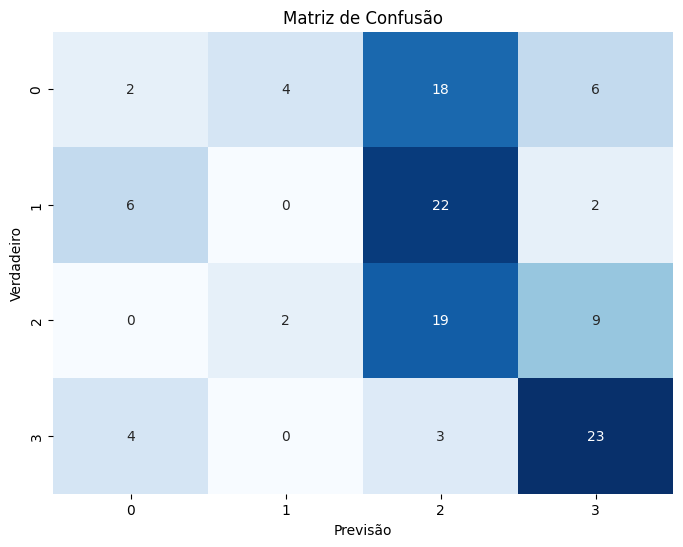

Métricas para RNA usando VGG:
Acurácia: 0.7417
Sensibilidade (Recall): 0.7417
Especificidade: 0.7417
F1-Score: 0.6787


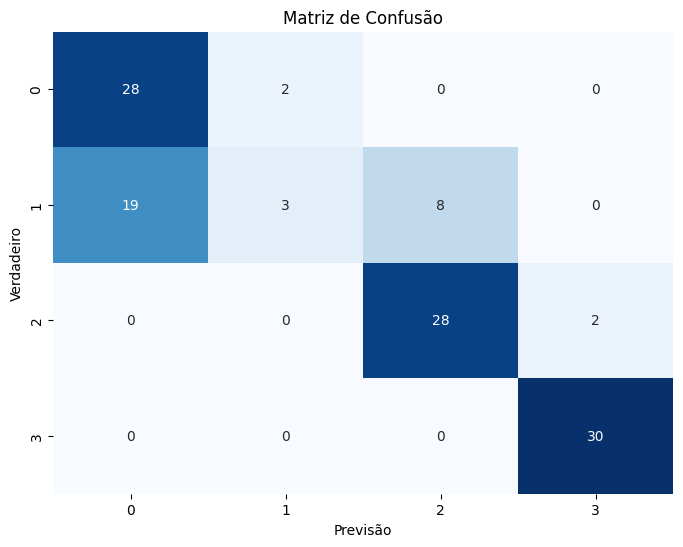

In [19]:
# treinando o modelo e validando com os dados de validação
model_rf_lbp, model_rf_vgg = random_forest(X_train_lbp, X_train_vgg, y_train)
print(f'Métricas para Randon Forest usando LBP:')
predicoes_metricas(model_rf_lbp, X_valid_lbp, y_valid)
print(f'Métricas para Randon Forest usando VGG:')
predicoes_metricas(model_rf_vgg, X_valid_vgg, y_valid)

model_svm_lbp, model_svm_vgg = svm(X_train_lbp, X_train_vgg, y_train)
print(f'Métricas para SVM usando LBP:')
predicoes_metricas(model_svm_lbp, X_valid_lbp, y_valid)
print(f'Métricas para SVM usando VGG:')
predicoes_metricas(model_svm_vgg, X_valid_vgg, y_valid)

model_rna_lbp, model_rna_vgg = rna(X_train_lbp, X_train_vgg, y_train)
print(f'Métricas para RNA usando LBP:')
predicoes_metricas(model_rna_lbp, X_valid_lbp, y_valid)
print(f'Métricas para RNA usando VGG:')
predicoes_metricas(model_rna_vgg, X_valid_vgg, y_valid)

### Carregando a base de Teste e extraindo as características

In [20]:
# Criação do DataFrame de Teste
df_teste = criar_dataframe_imagens(test_directory)
#print(df_teste)
# Extrair as caracteristicas da base de Teste
X_test_lbp, X_test_vgg, y_test = extrair_caracteristicas(df_teste, output_directory, 'test')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

### Aplicando os modelos treinados nos dados de teste.

Métricas para Randon Forest usando LBP na base de teste:
Acurácia: 0.5660
Sensibilidade (Recall): 0.5724
Especificidade: 0.5660
F1-Score: 0.5638


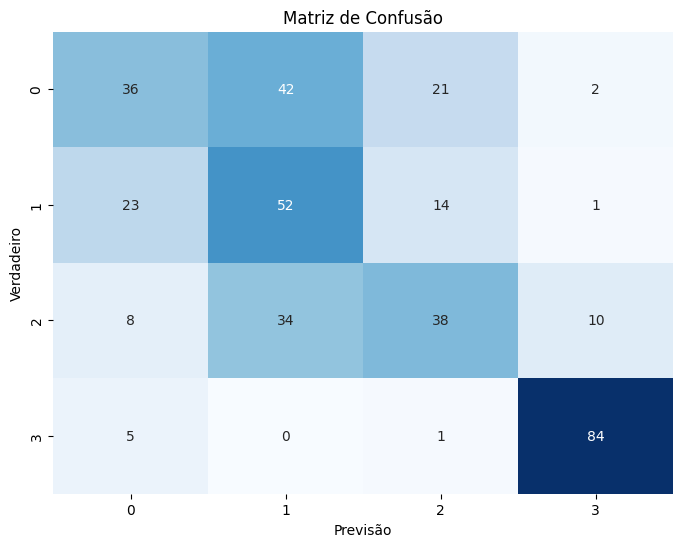

Métricas para Randon Forest usando VGG na base de teste:
Acurácia: 0.8895
Sensibilidade (Recall): 0.8870
Especificidade: 0.8895
F1-Score: 0.8856


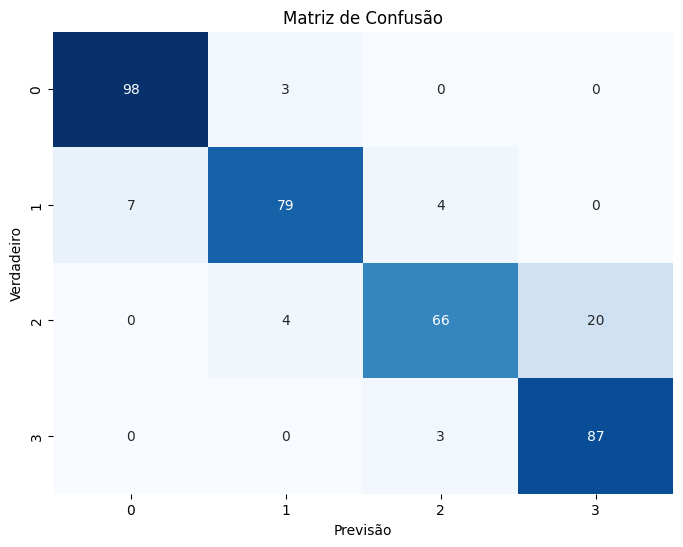

Métricas para SVM usando LBP na base de teste:
Acurácia: 0.3046
Sensibilidade (Recall): 0.3139
Especificidade: 0.3046
F1-Score: 0.2039


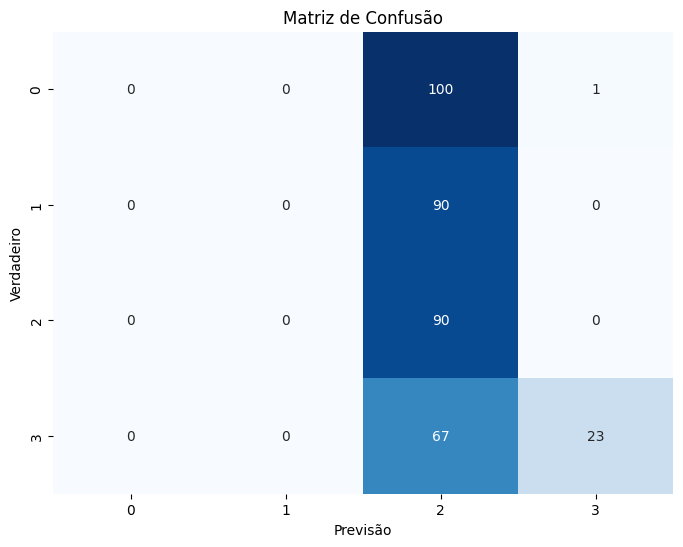

Métricas para SVM usando VGG na base de teste:
Acurácia: 0.8868
Sensibilidade (Recall): 0.8855
Especificidade: 0.8868
F1-Score: 0.8860


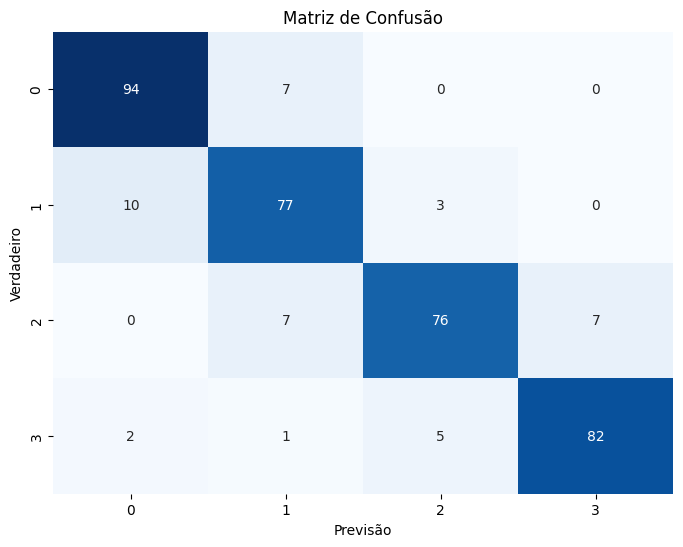

Métricas para RNA usando LBP na base de teste:
Acurácia: 0.5310
Sensibilidade (Recall): 0.5415
Especificidade: 0.5310
F1-Score: 0.5115


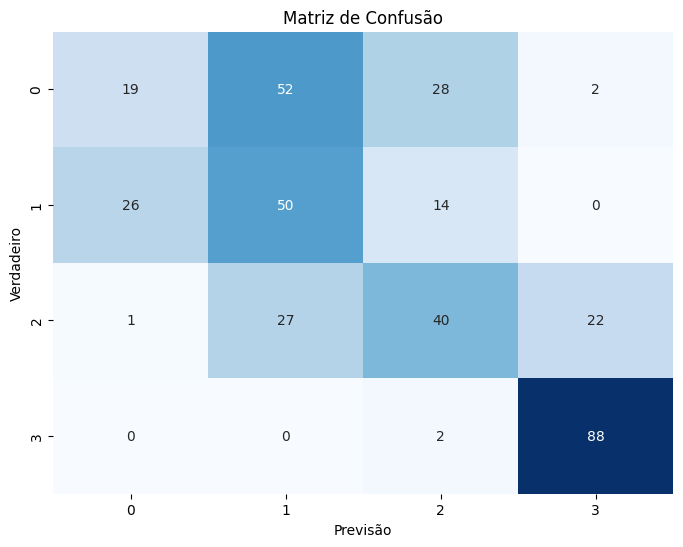

Métricas para RNA usando VGG na base de teste:
Acurácia: 0.9084
Sensibilidade (Recall): 0.9071
Especificidade: 0.9084
F1-Score: 0.9073


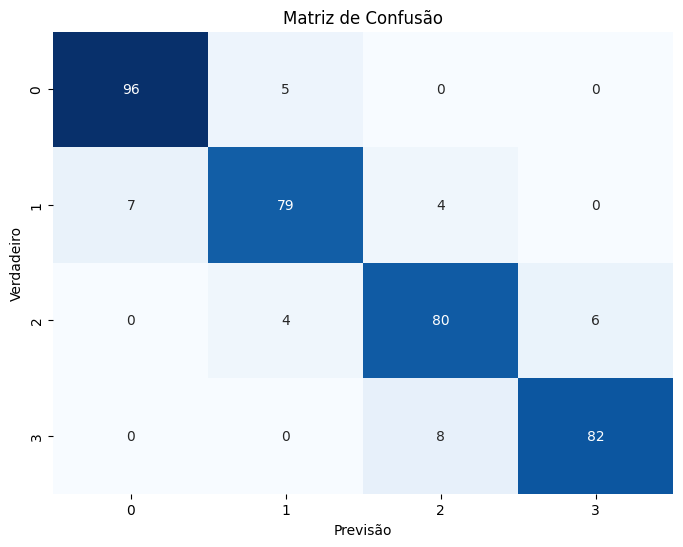

In [21]:
# Execução o modelo treinado na base de teste

print(f'Métricas para Randon Forest usando LBP na base de teste:')
predicoes_metricas(model_rf_lbp, X_test_lbp, y_test)
print(f'Métricas para Randon Forest usando VGG na base de teste:')
predicoes_metricas(model_rf_vgg, X_test_vgg, y_test)

print(f'Métricas para SVM usando LBP na base de teste:')
predicoes_metricas(model_svm_lbp, X_test_lbp, y_test)
print(f'Métricas para SVM usando VGG na base de teste:')
predicoes_metricas(model_svm_vgg, X_test_vgg, y_test)

print(f'Métricas para RNA usando LBP na base de teste:')
predicoes_metricas(model_rna_lbp, X_test_lbp, y_test)
print(f'Métricas para RNA usando VGG na base de teste:')
predicoes_metricas(model_rna_vgg, X_test_vgg, y_test)


### Conclusão

###### Teste

## Redes Neurais

### Importação das Bibliotecas

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers, models, optimizers

#### Configurações dos Modelos VGG16 e Resnet50

In [23]:
def build_vgg16(input_shape=(224, 224, 3), num_classes=4):
    # Carrega o modelo VGG16 com pesos pré-treinados, excluindo a última camada fully connected
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Congelar o modelo base

    # Adiciona novas camadas fully connected
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Saída para 4 classes
    ])
    return model

def build_resnet50(input_shape=(224, 224, 3), num_classes=4):
    # Carrega o modelo ResNet50 com pesos pré-treinados, excluindo a última camada fully connected
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Congelar o modelo base

    # Adiciona novas camadas fully connected
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Saída para 4 classes
    ])
    return model


### Configuração do ImageDataGenerator

In [24]:
# Gerador para o conjunto de treino e validação com Data Augmentation
train_datagen_com_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Gerador para o conjunto de treino e validação sem Data Augmentation
val_datagen_sem_aug = ImageDataGenerator(rescale=1./255)
test_datagen_sem_aug = ImageDataGenerator(rescale=1./255)


#### Configuração para a geração dos treinos e validação

In [25]:
# Gerador de treino com Data Augmentation
train_generator_com_aug = train_datagen_com_aug.flow_from_dataframe(
    dataframe=df_treino,
    x_col='imagem',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Gerador de validação sem Data Augmentation
validation_generator_sem_aug = val_datagen_sem_aug.flow_from_dataframe(
    dataframe=df_validacao,
    x_col='imagem',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator_sem_aug = test_datagen_sem_aug.flow_from_dataframe(
    dataframe=df_treino,
    x_col='imagem',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 473 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 371 validated image filenames belonging to 4 classes.


### Executando os treinos e validação

In [26]:
# Compilar e treinar o VGG16
vgg16_model = build_vgg16(num_classes=4)
vgg16_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

history_vgg16 = vgg16_model.fit(
    train_generator_com_aug,
    steps_per_epoch=train_generator_com_aug.samples // train_generator_com_aug.batch_size,
    epochs=10,
    validation_data=validation_generator_sem_aug,
    validation_steps=validation_generator_sem_aug.samples // validation_generator_sem_aug.batch_size
)

# Compilar e treinar o ResNet50
resnet50_model = build_resnet50(num_classes=4)
resnet50_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

history_resnet50 = resnet50_model.fit(
    train_generator_com_aug,
    steps_per_epoch=train_generator_com_aug.samples // train_generator_com_aug.batch_size,
    epochs=10,
    validation_data=validation_generator_sem_aug,
    validation_steps=validation_generator_sem_aug.samples // validation_generator_sem_aug.batch_size
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 366s 26s/step - accuracy: 0.3733 - loss: 1.4434 - val_accuracy: 0.5625 - val_loss: 0.8935
Epoch 2/10
 1/14 ━━━━━━━━━━━━━━━━━━━━ 4:42 22s/step - accuracy: 0.5000 - loss: 1.0779

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5000 - loss: 1.0779 - val_accuracy: 0.5000 - val_loss: 1.0874
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 358s 25s/step - accuracy: 0.6267 - loss: 0.8720 - val_accuracy: 0.7396 - val_loss: 0.6256
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7500 - loss: 0.6351 - val_accuracy: 0.7083 - val_loss: 0.6879
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 361s 26s/step - accuracy: 0.7880 - loss: 0.5320 - val_accuracy: 0.6979 - val_loss: 0.7107
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7188 - loss: 0.5894 - val_accuracy: 0.6667 - val_loss: 0.7612
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 362s 26s/step - accuracy: 0.8324 - loss: 0.4335 - val_accuracy: 0.6042 - val_loss: 0.8009
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7188 - loss: 0.5808 - val_accuracy: 0.7917 - val_loss: 0.6084
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 358s 25s/step - accuracy: 0.8321 - loss: 0.4129 - val_accuracy: 0.7083 - val_loss: 0.

In [30]:
test_datagen_sem_aug = ImageDataGenerator(rescale=1./255)

test_generator_sem_aug = test_datagen_sem_aug.flow_from_dataframe(
    dataframe=df_treino,
    x_col='imagem',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Avaliação do modelo VGG16 no conjunto de teste
test_loss, test_accuracy = vgg16_model.evaluate(test_generator_sem_aug, steps=test_generator_sem_aug.samples // test_generator_sem_aug.batch_size)
print("Test Accuracy (VGG16):", test_accuracy)

# Avaliação do modelo ResNet50 no conjunto de teste
test_loss, test_accuracy = resnet50_model.evaluate(test_generator_sem_aug, steps=test_generator_sem_aug.samples // test_generator_sem_aug.batch_size)
print("Test Accuracy (ResNet50):", test_accuracy)

Found 473 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 292s 21s/step - accuracy: 0.8932 - loss: 0.2620
Test Accuracy (VGG16): 0.8973214030265808
14/14 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step - accuracy: 0.4673 - loss: 1.2153
Test Accuracy (ResNet50): 0.4799107015132904


In [31]:
# Previsões do modelo VGG16
predictions_vgg16 = vgg16_model.predict(test_generator_sem_aug, steps=test_generator_sem_aug.samples // test_generator_sem_aug.batch_size)
predicted_classes_vgg16 = predictions_vgg16.argmax(axis=-1)  # Classes previstas

# Previsões do modelo ResNet50
predictions_resnet50 = resnet50_model.predict(test_generator_sem_aug, steps=test_generator_sem_aug.samples // test_generator_sem_aug.batch_size)
predicted_classes_resnet50 = predictions_resnet50.argmax(axis=-1)  # Classes previstas

14/14 ━━━━━━━━━━━━━━━━━━━━ 294s 21s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 92s 7s/step


In [33]:
from sklearn.metrics import classification_report

# Comparação para o modelo VGG16
true_classes = test_generator_sem_aug.classes  # Classes verdadeiras
print(true_classes)
class_labels = list(test_generator_sem_aug.class_indices.keys())  # Nomes das classes
print(class_labels)

print("Classification Report for VGG16:")
print(classification_report(true_classes, predicted_classes_vgg16, target_names=class_labels))

# Comparação para o modelo ResNet50
print("Classification Report for ResNet50:")
print(classification_report(true_classes, predicted_classes_resnet50, target_names=class_labels))


[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

ValueError: Found input variables with inconsistent numbers of samples: [473, 448]

In [34]:
from sklearn.metrics import confusion_matrix

# Exemplo com VGG16
conf_matrix_vgg16 = confusion_matrix(true_classes, predicted_classes_vgg16)
print("Confusion Matrix for VGG16:")
print(conf_matrix_vgg16)

# Exemplo com ResNet50
conf_matrix_resnet50 = confusion_matrix(true_classes, predicted_classes_resnet50)
print("Confusion Matrix for ResNet50:")
print(conf_matrix_resnet50)


ValueError: Found input variables with inconsistent numbers of samples: [473, 448]

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Função para calcular Sensibilidade, Especificidade e F1-Score por classe
def calculate_metrics(conf_matrix):
    metrics = []
    for i in range(len(conf_matrix)):
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        TN = conf_matrix.sum() - (FP + FN + TP)

        # Sensibilidade (Recall)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

        # Especificidade
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        # F1-Score
        f1 = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0

        metrics.append({
            'Class': i,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'F1-Score': f1
        })

    return metrics

# Cálculo das métricas para VGG16
metrics_vgg16 = calculate_metrics(conf_matrix_vgg16)
print("Metrics for VGG16:")
for metric in metrics_vgg16:
    print(metric)

# Cálculo das métricas para ResNet50
metrics_resnet50 = calculate_metrics(conf_matrix_resnet50)
print("Metrics for ResNet50:")
for metric in metrics_resnet50:
    print(metric)


In [ ]:
from sklearn.metrics import classification_report

# Relatório de classificação para VGG16
print("Classification Report for VGG16:")
print(classification_report(true_classes, predicted_classes_vgg16, target_names=class_labels))

# Relatório de classificação para ResNet50
print("Classification Report for ResNet50:")
print(classification_report(true_classes, predicted_classes_resnet50, target_names=class_labels))
